<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/HippoWithResUNetandU_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Setup and Imports
# Purpose: Import libraries, mount Google Drive, and set random seed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import cv2
import zipfile
from google.colab import drive
drive.mount('/content/drive')
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"TensorFlow version: {tf.__version__}")
print("Environment setup complete.")

Mounted at /content/drive
TensorFlow version: 2.18.0
Environment setup complete.


# Define Metrics

In [36]:
# Purpose: Define custom metrics for segmentation evaluation (Dice, IoU, precision, recall).
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.float32)
    dice = dice_coef(y_true, y_pred_bin).numpy()
    iou_score = iou(y_true, y_pred_bin).numpy()
    y_true_f = y_true.flatten()
    y_pred_f = y_pred_bin.flatten()
    precision = np.sum(y_true_f * y_pred_f) / (np.sum(y_pred_f) + 1e-6)
    recall = np.sum(y_true_f * y_pred_f) / (np.sum(y_true_f) + 1e-6)
    return dice, iou_score, precision, recall

print("Metrics defined: Dice, IoU, Precision, Recall")

Metrics defined: Dice, IoU, Precision, Recall


# Data Loading

In [ ]:
# Purpose: Load and preprocess hippocampus MRI images and masks from zip file.
def load_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img.astype(np.float32)

def load_mask(mask_path, target_size=(128, 128)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to load mask: {mask_path}")
    mask = cv2.resize(mask, target_size)
    mask = (mask > 0).astype(np.float32)
    mask = mask[:, :, np.newaxis]
    return mask

# Unzip dataset
zip_path = '/content/hippocampus segmentation dataset.zip'
extract_path = '/content/hippocampus_dataset'
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found: {zip_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Recursive file search
def find_files(directory, extensions):
    files = []
    for root, _, filenames in os.walk(directory):
        for f in filenames:
            if any(f.lower().endswith(ext) for ext in extensions):
                files.append(os.path.join(root, f))
    return sorted(files)

# Find images and masks
image_extensions = ('.jpg', '.jpeg', '.png')
mask_extensions = ('.jpg', '.jpeg', '.png')
all_files = find_files(extract_path, image_extensions + mask_extensions)
image_files = [f for f in all_files if not any(kw in os.path.basename(f).lower() for kw in ['mask', '_mask', 'seg', 'segmentation'])]
mask_files = [f for f in all_files if any(kw in os.path.basename(f).lower() for kw in ['mask', '_mask', 'seg', 'segmentation'])]

# Debug prints
print(f"Found {len(image_files)} image files, {len(mask_files)} mask files")
if image_files:
    print("Sample images:", image_files[:3])
if mask_files:
    print("Sample masks:", mask_files[:3])

# Pair images and masks
train_data = []
if len(image_files) == len(mask_files):
    # Try index-based pairing if equal number of files
    print("Attempting index-based pairing (sorted files)")
    train_data = list(zip(image_files, mask_files))
else:
    # Flexible name-based pairing
    print("Attempting name-based pairing")
    for img in image_files:
        img_name = os.path.basename(img).lower().split('.')[0]
        for mask in mask_files:
            mask_name = os.path.basename(mask).lower().split('.')[0]
            # Match if names share a common identifier
            if img_name.replace('img', '') in mask_name or mask_name.replace('mask', '').replace('seg', '') in img_name:
                train_data.append((img, mask))
                break
            # Alternative: Replace 'img' with 'mask' or 'seg'
            if img_name.replace('img', 'mask') == mask_name or img_name.replace('img', 'seg') == mask_name:
                train_data.append((img, mask))
                break

print(f"Paired {len(train_data)} image-mask pairs")
if not train_data:
    # Debug unmatched files
    print("Unmatched images:", [os.path.basename(f) for f in image_files[:5]])
    print("Unmatched masks:", [os.path.basename(f) for f in mask_files[:5]])
    raise ValueError("No image-mask pairs found. Check file names or directory structure. See unmatched files above.")

# Load data
X = np.array([load_image(img_path) for img_path, _ in train_data])
Y = np.array([load_mask(mask_path) for _, mask_path in train_data])

# Split data
if X.shape[0] == 0:
    raise ValueError("No data loaded. Cannot proceed with empty dataset.")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")

Found 499 image files, 998 mask files
Sample images: ['/content/hippocampus_dataset/aug/images/img_aug1.jpg', '/content/hippocampus_dataset/aug/images/img_aug10.jpg', '/content/hippocampus_dataset/aug/images/img_aug100.jpg']
Sample masks: ['/content/hippocampus_dataset/aug/masks/left/maskleft_aug1.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug10.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug100.jpg']
Attempting name-based pairing
Paired 499 image-mask pairs
X_train shape: (449, 128, 128, 3), X_test shape: (50, 128, 128, 3)
Y_train shape: (449, 128, 128, 1), Y_test shape: (50, 128, 128, 1)


# Visualize Dataset Samples


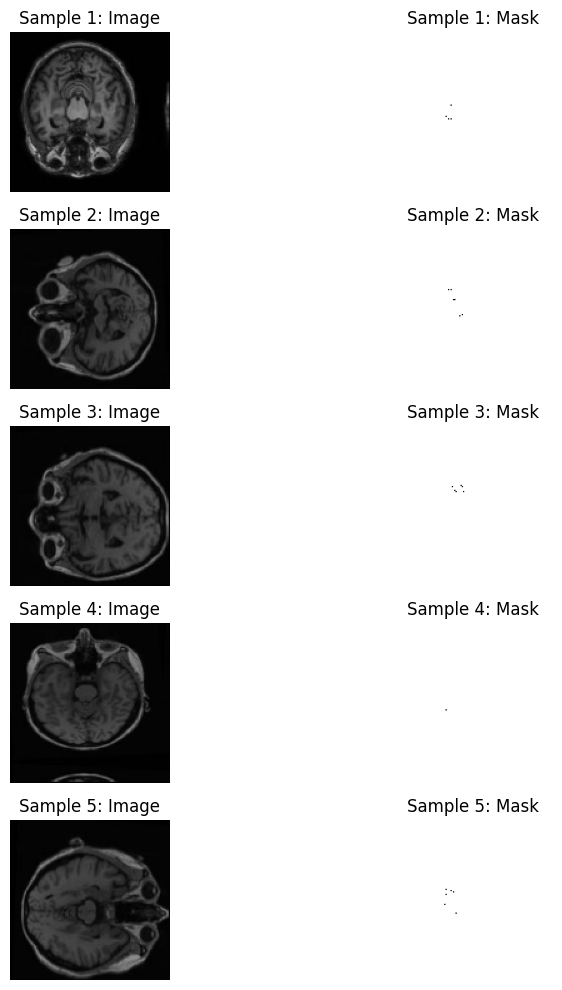

Displayed 5 sample image-mask pairs.


In [ ]:
# Purpose: Display sample image-mask pairs from the training set to verify data loading.
import matplotlib.pyplot as plt

def visualize_samples(X, Y, num_samples=5):
    if len(X) < num_samples:
        print(f"Warning: Only {len(X)} samples available, displaying all.")
        num_samples = len(X)

    plt.figure(figsize=(10, num_samples * 2))
    for i in range(num_samples):
        # Image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Sample {i+1}: Image")
        plt.axis('off')

        # Mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title(f"Sample {i+1}: Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 5 samples from training set
visualize_samples(X_train, Y_train, num_samples=5)
print("Displayed 5 sample image-mask pairs.")

# Define Montage Function


In [ ]:
# Purpose: Create montages of images or masks for visualization.
def custom_montage(images, n_rows=5, n_cols=5, cmap='gray'):
    if len(images) == 0:
        return None
    images = images[:n_rows * n_cols]
    h, w = images.shape[1:3] if images.ndim == 4 else (images.shape[1], images.shape[2])
    if images.ndim == 4:
        images = images[..., 0] if images.shape[-1] == 1 else images
    montage = np.zeros((h * n_rows, w * n_cols, images.shape[-1] if images.ndim > 3 else 1), dtype=np.float32)
    for i in range(min(len(images), n_rows * n_cols)):
        r, c = divmod(i, n_cols)
        img = images[i]
        montage[r*h:(r+1)*h, c*w:(c+1)*w] = img[..., np.newaxis] if img.ndim == 2 else img
    plt.figure(figsize=(n_cols*2, n_rows*2))
    plt.imshow(montage.squeeze() if montage.shape[-1] == 1 else montage, cmap=cmap)
    plt.axis('off')
    return plt.gcf()

print("Montage function defined.")

Montage function defined.


# Define ResUNet Model

In [ ]:
# Purpose: Define the ResUNet model as a baseline for segmentation.
def res_block(x, filters):
    conv1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    conv2 = layers.Conv2D(filters, 3, padding='same')(conv1)
    shortcut = layers.Conv2D(filters, 1, padding='same')(x)
    return layers.Add()([conv2, shortcut])

def build_resunet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    x1 = res_block(inputs, 64)
    x = layers.MaxPooling2D()(x1)
    x2 = res_block(x, 128)
    x = layers.MaxPooling2D()(x2)
    x = res_block(x, 256)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, x2])
    x = res_block(x, 128)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, x1])
    x = res_block(x, 64)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return keras.models.Model(inputs, outputs)

resunet_model = build_resunet()
resunet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[dice_coef, iou]
)
resunet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     33,024 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ conv2d_7[0][0],   │
│                     │ 256)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ add_2[0][0]       │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]

 Total params: 1,986,369 (7.58 MB)

 Trainable params: 1,986,369 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

# Define Pre-Trained U-Net with ResNet50

In [ ]:
# Purpose: Build a U-Net with pre-trained ResNet50 backbone for segmentation.
def build_unet_resnet50(input_shape=(128, 128, 3)):
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = True

    layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']
    skip_layers = [base_model.get_layer(name).output for name in layer_names]

    inputs = layers.Input(input_shape)
    x = inputs
    x = base_model(x)

    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip_layers[3]])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip_layers[2]])
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip_layers[1]])
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip_layers[0]])
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return keras.models.Model(inputs, outputs)

unet_resnet50_model = build_unet_resnet50()
unet_resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[dice_coef, iou]
)
unet_resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 37,707,649 (143.84 MB)

 Trainable params: 37,654,529 (143.64 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Cell 8: Training


In [ ]:
# Cell 8: Training
# Purpose: Train ResUNet and U-Net (ResNet50) models with augmentation, save to Google Drive.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Debugging: Verify input shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Data augmentation
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

batch_size = 8
drive_model_path = '/content/drive/MyDrive/Hippocampus_Models'
os.makedirs(drive_model_path, exist_ok=True)

# Test model compatibility
test_input = X_train[:1]  # Single sample (1, 128, 128, 3)
try:
    print("Testing ResUNet model with sample input...")
    resunet_pred = resunet_model.predict(test_input, verbose=0)
    print(f"ResUNet prediction shape: {resunet_pred.shape}")
except Exception as e:
    print(f"ResUNet model test failed: {str(e)}")
    raise

try:
    print("Testing U-Net_ResNet50 model with sample input...")
    unet_pred = unet_resnet50_model.predict(test_input, verbose=0)
    print(f"U-Net_ResNet50 prediction shape: {unet_pred.shape}")
except Exception as e:
    print(f"U-Net_ResNet50 model test failed: {str(e)}")
    # Additional debugging: Test base_model separately
    try:
        from tensorflow.keras.applications import ResNet50
        print("Testing ResNet50 base model alone...")
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
        base_pred = base_model.predict(test_input, verbose=0)
        print(f"ResNet50 base model prediction shape: {base_pred.shape}")
        print("ResNet50 layer names (first 10):", [layer.name for layer in base_model.layers][:10])
    except Exception as base_e:
        print(f"ResNet50 base model test failed: {str(base_e)}")
    print("Skipping U-Net_ResNet50 training due to model error. Please check Cell 7 layer_names.")
    unet_resnet50_results = None
else:
    print("U-Net_ResNet50 model test passed.")

# Train ResUNet
resunet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(drive_model_path, 'ResUNet.h5'),
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs_ResUNet')
]
if X_train.shape[0] > 0:
    print("Training ResUNet model...")
    resunet_results = resunet_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=resunet_callbacks,
        verbose=1
    )
    print("ResUNet training complete.")

# Train U-Net (ResNet50) only if test passed
if X_train.shape[0] > 0 and unet_resnet50_results is not None:
    print("Training U-Net_ResNet50 model...")
    unet_resnet50_callbacks = [
        keras.callbacks.ModelCheckpoint(
            os.path.join(drive_model_path, 'U-Net_ResNet50.h5'),
            save_best_only=True,
            monitor='val_loss'
        ),
        keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        keras.callbacks.TensorBoard(log_dir='logs_U-Net_ResNet50')
    ]
    unet_resnet50_results = unet_resnet50_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=unet_resnet50_callbacks,
        verbose=1
    )
    print("U-Net_ResNet50 training complete.")

print("Training complete. Models saved to Google Drive.")

X_train shape: (449, 128, 128, 3), Y_train shape: (449, 128, 128, 1)
X_test shape: (50, 128, 128, 3), Y_test shape: (50, 128, 128, 1)
Testing ResUNet model with sample input...
ResUNet prediction shape: (1, 128, 128, 1)
Testing U-Net_ResNet50 model with sample input...
U-Net_ResNet50 model test failed: 'Exception encountered when calling Functional.call().\n\n\x1b136613081179536\x1b\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 128, 128, 3), dtype=float32)\n  • training=False\n  • mask=None'
Testing ResNet50 base model alone...
ResNet50 base model prediction shape: (1, 4, 4, 2048)
ResNet50 layer names (first 10): ['input_layer_3', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu']
Skipping U-Net_ResNet50 training due to model error. Please check Cell 7 layer_names.
Training ResUNet model...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - dice_coef: 0.9996 -

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0028
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0028 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0028
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9995 - val_iou: 0.9990 - val_loss: 0.0028
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0029

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0029 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0028
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9997 - iou: 0.9994 - loss: 0.0026 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9991 - val_loss: 0.0028
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0028
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0028 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0028
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0028 - val_dice_coef: 0.9995 - val_iou: 0.9990 - val_loss: 0.0028
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9993 - val_loss: 0.0027
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0028 - val_dice_coef: 0.9995 - val_iou: 0.9991 - val_loss: 0.0028
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0028
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0028
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0027
Epoch 22/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0028
Epoch 23/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 24/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 25/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9995 - val_iou: 0.9991 - val_loss: 0.0028
Epoch 26/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0028 - val_dice_coef: 0.9996 - val_iou: 0.9993 - val_loss: 0.0028
Epoch 27/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0029 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0027
Epoch 30/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9995 - val_iou: 0.9989 - val_loss: 0.0029
Epoch 31/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0028
Epoch 32/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0027
Epoch 33/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0027
Epoch 34/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9995 - val_iou: 0.9990 - val_loss: 0.0028
Epoch 35/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9993 - val_loss: 0.0027
Epoch 36/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0027
Epoch 37/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9995 - val_iou: 0.9991 - val_loss: 0.0027
Epoch 38/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0027
Epoch 39/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0028
Epoch 40/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0028
Epoch 41/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0027
Epoch 44/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0028 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0027
Epoch 45/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9994 - val_iou: 0.9988 - val_loss: 0.0028
Epoch 46/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0028
Epoch 47/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0026 - val_dice_coef: 0.9996 - val_iou: 0.9991 - val_loss: 0.0027
Epoch 48/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0027 - val_dice_coef: 0.9996 - val_iou: 0.9993 - val_loss: 0.0027
Epoch 49/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 

Checking metric functions...
dice_coef type: <class 'function'>
iou type: <class 'function'>
Skipping U-Net_ResNet50 evaluation: training results not available.
Evaluating ResUNet...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


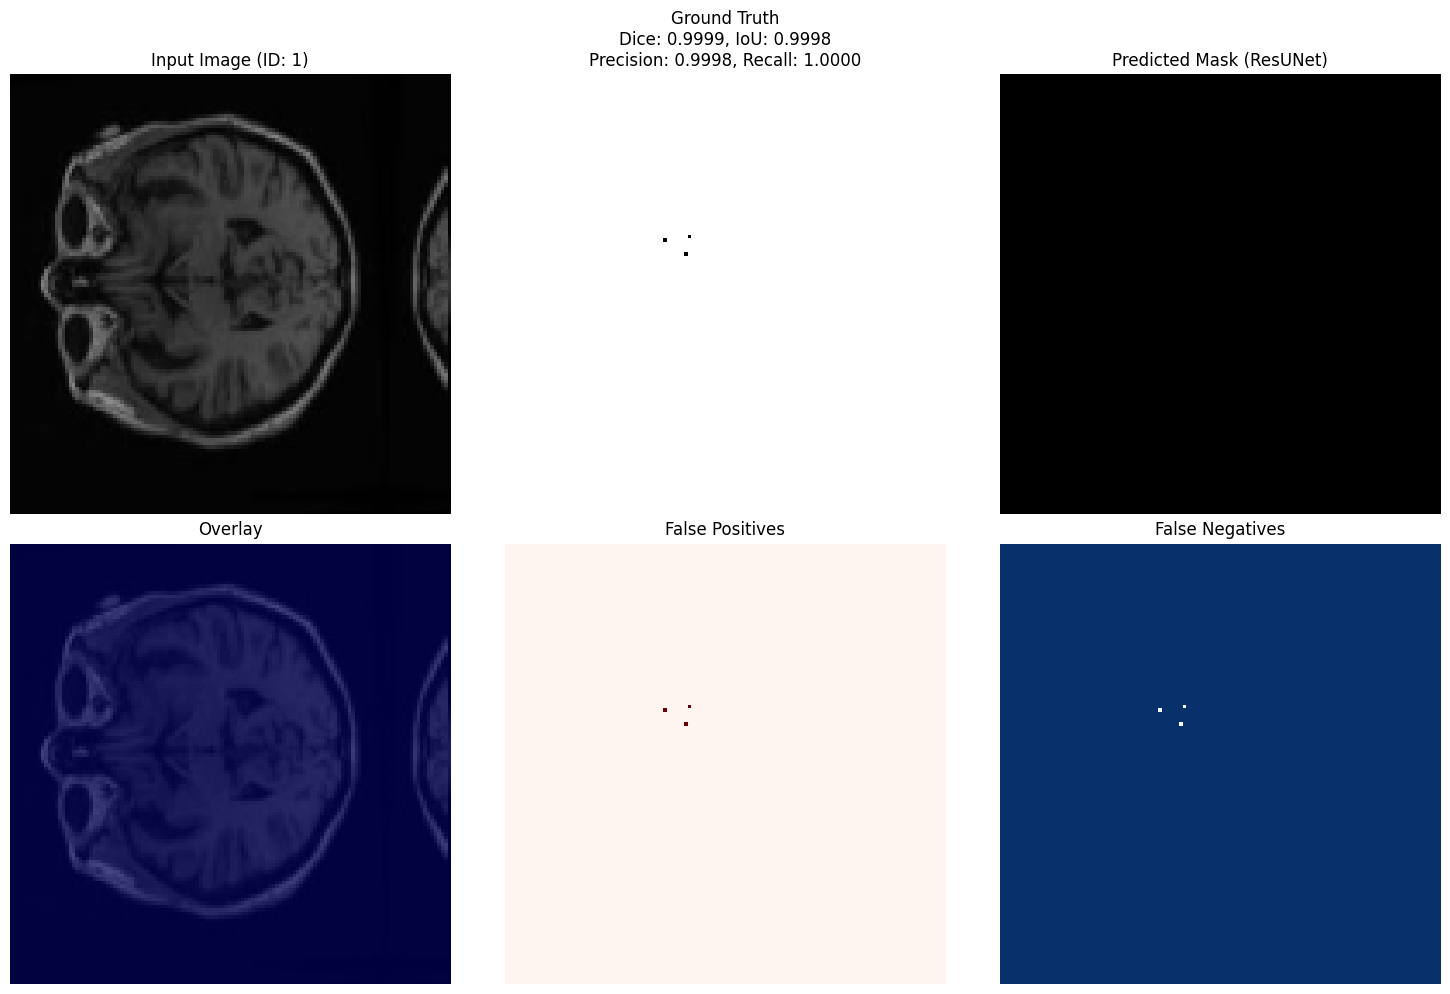

Error computing metrics for sample 2: 'numpy.float32' object is not callable
Error computing metrics for sample 3: 'numpy.float32' object is not callable
Error computing metrics for sample 4: 'numpy.float32' object is not callable
Error computing metrics for sample 5: 'numpy.float32' object is not callable


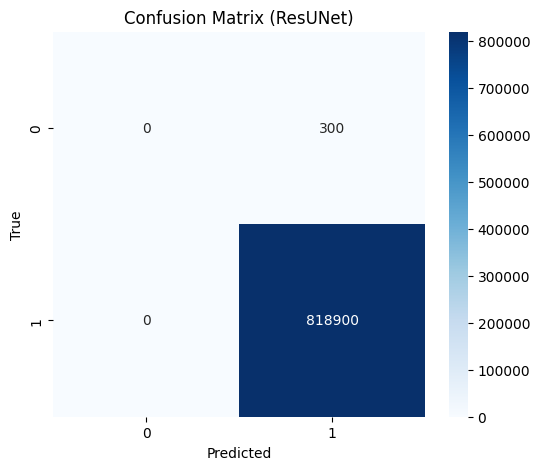

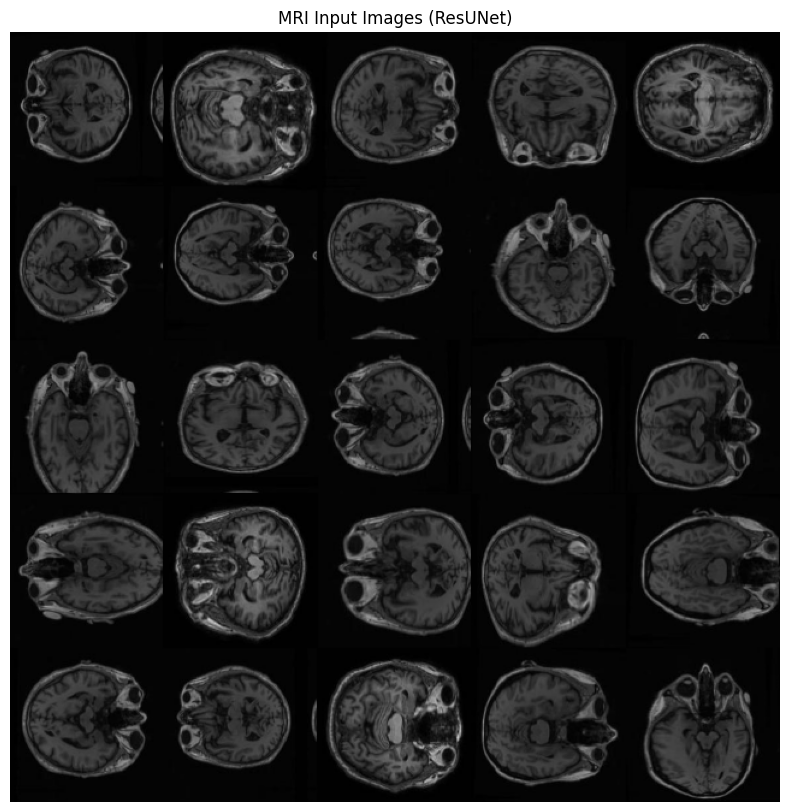

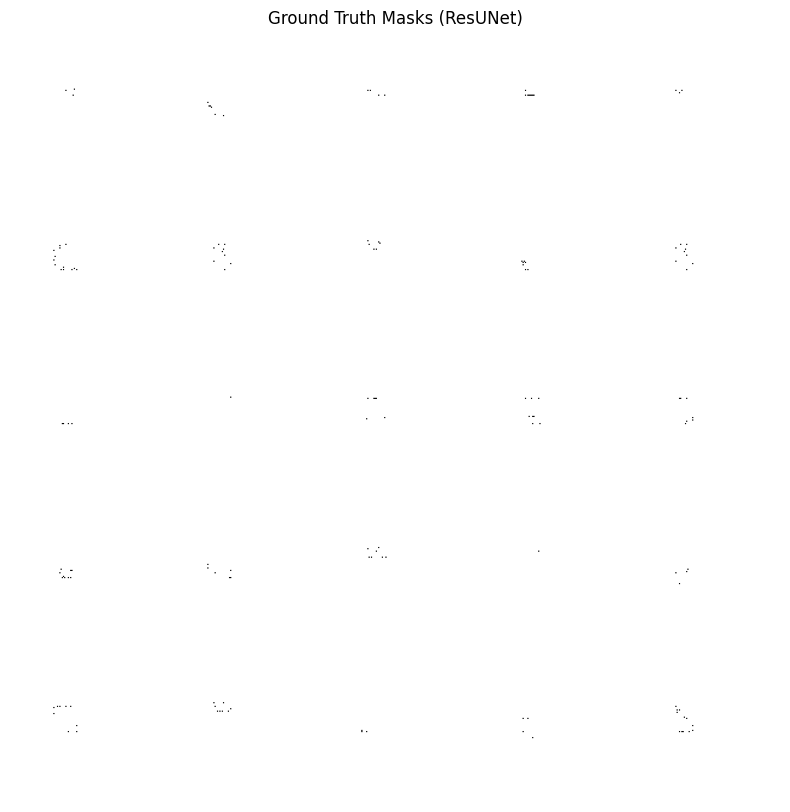

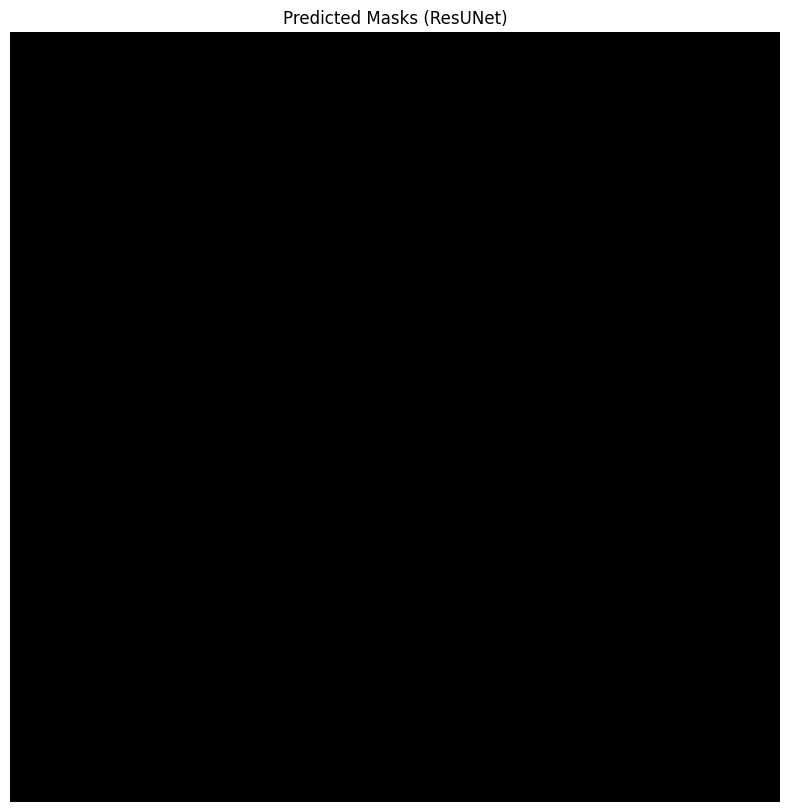

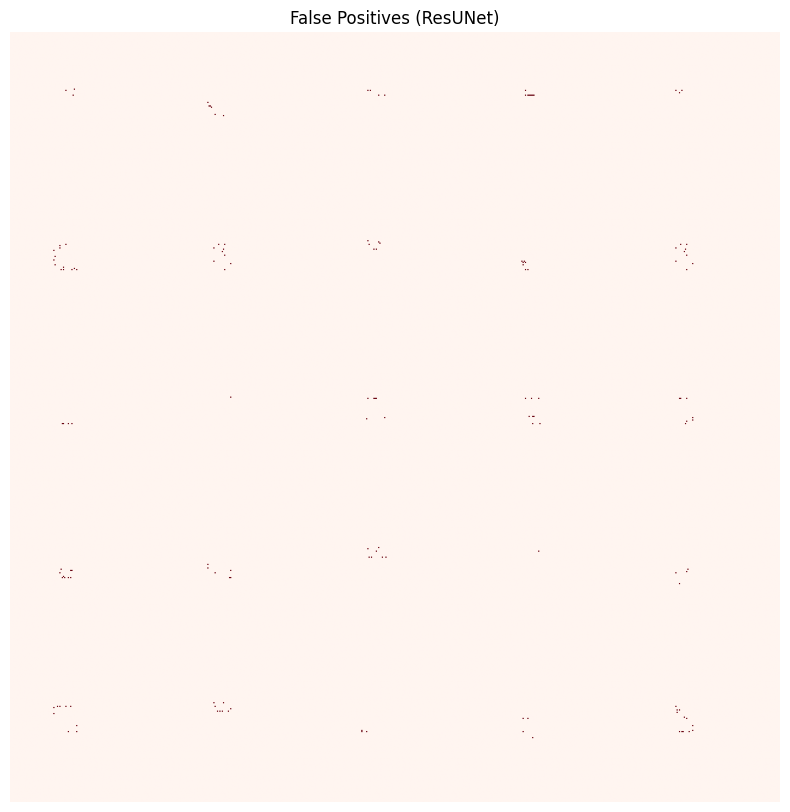

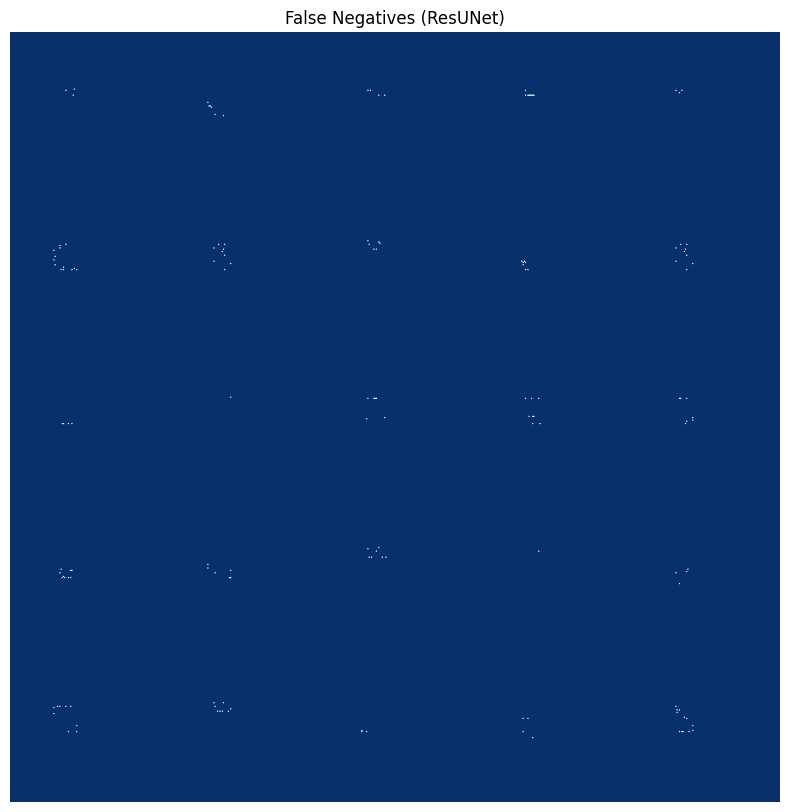

Metrics Table:
     Model Sample ID      Dice       IoU  Precision  Recall
0  ResUNet         1  0.999908  0.999817   0.999817     1.0


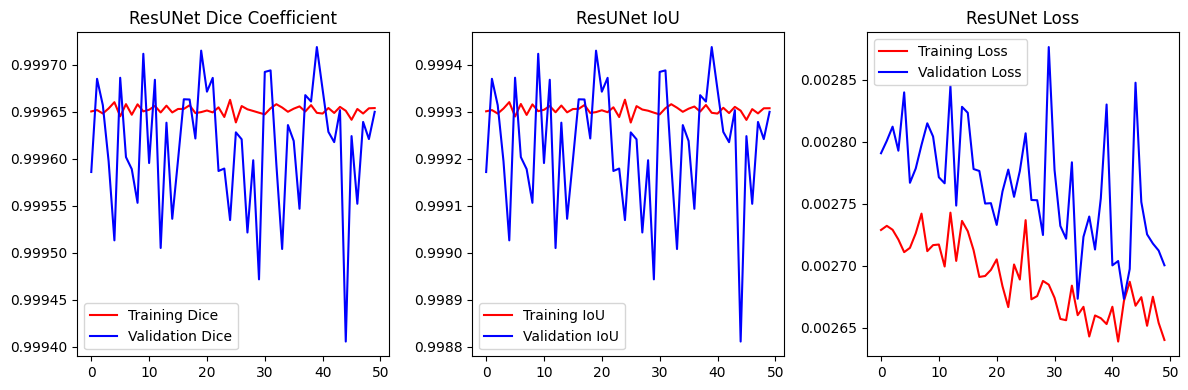

Evaluation complete.


In [37]:
# Cell 9: Evaluation and Visualization
# Purpose: Generate per-sample visualizations, montages, confusion matrices, and metrics table.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import tensorflow as tf

# Verify metric functions
print("Checking metric functions...")
print(f"dice_coef type: {type(dice_coef)}")
print(f"iou type: {type(iou)}")
if not callable(dice_coef) or not callable(iou):
    raise ValueError("dice_coef or iou is not a function. Please re-run Cell 2 to define them correctly.")

# Modified compute_metrics to avoid TypeError
def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    dice = dice_coef(y_true, y_pred_bin)
    iou_score = iou(y_true, y_pred_bin)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred_bin, [-1])
    precision = tf.reduce_sum(y_true_f * y_pred_f) / (tf.reduce_sum(y_pred_f) + 1e-6)
    recall = tf.reduce_sum(y_true_f * y_pred_f) / (tf.reduce_sum(y_true_f) + 1e-6)
    return dice.numpy(), iou_score.numpy(), precision.numpy(), recall.numpy()

def extract_id(file_path, prefix='img_'):
    return os.path.basename(file_path).replace(prefix, '').split('.')[0]

metrics_table = []
models_to_evaluate = [('ResUNet', resunet_model, resunet_results)]
try:
    if unet_resnet50_results is not None:
        models_to_evaluate.append(('U-Net_ResNet50', unet_resnet50_model, unet_resnet50_results))
    else:
        print("Skipping U-Net_ResNet50 evaluation: training results not available.")
except NameError:
    print("Skipping U-Net_ResNet50 evaluation: unet_resnet50_results not defined.")

for model_name, model, results in models_to_evaluate:
    if X_test.shape[0] == 0:
        print(f"No test data for {model_name} evaluation.")
        continue

    print(f"Evaluating {model_name}...")
    preds = model.predict(X_test, verbose=1)

    for id in range(min(5, X_test.shape[0])):
        pred = preds[id]
        y_true = Y_test[id]
        try:
            dice, iou, precision, recall = compute_metrics(y_true, pred)
        except Exception as e:
            print(f"Error computing metrics for sample {id+1}: {str(e)}")
            continue

        false_positives = (pred > 0.5).astype(np.float32) - y_true.clip(0, 1)
        false_negatives = y_true - (pred > 0.5).astype(np.float32).clip(0, 1)

        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
        ax[0, 0].imshow(X_test[id], cmap='gray')
        ax[0, 0].set_title(f"Input Image (ID: {extract_id(train_data[id][0], 'img_aug')})")
        ax[0, 0].axis('off')
        ax[0, 1].imshow(y_true[:, :, 0], cmap='gray')
        ax[0, 1].set_title(f"Ground Truth\nDice: {dice:.4f}, IoU: {iou:.4f}\nPrecision: {precision:.4f}, Recall: {recall:.4f}")
        ax[0, 1].axis('off')
        ax[0, 2].imshow((pred > 0.5)[:, :, 0], cmap='gray')
        ax[0, 2].set_title(f"Predicted Mask ({model_name})")
        ax[0, 2].axis('off')
        ax[1, 0].imshow(X_test[id], cmap='gray')
        ax[1, 0].imshow((pred > 0.5)[:, :, 0], cmap='jet', alpha=0.5)
        ax[1, 0].set_title("Overlay")
        ax[1, 0].axis('off')
        ax[1, 1].imshow(false_positives[:, :, 0], cmap='Reds')
        ax[1, 1].set_title("False Positives")
        ax[1, 1].axis('off')
        ax[1, 2].imshow(false_negatives[:, :, 0], cmap='Blues')
        ax[1, 2].set_title("False Negatives")
        ax[1, 2].axis('off')
        plt.tight_layout()
        plt.show()

        metrics_table.append({
            'Model': model_name,
            'Sample ID': extract_id(train_data[id][0], 'img_aug'),
            'Dice': dice,
            'IoU': iou,
            'Precision': precision,
            'Recall': recall
        })

    y_true_f = Y_test.flatten()
    y_pred_f = (preds > 0.5).flatten()
    cm = confusion_matrix(y_true_f, y_pred_f)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({model_name})")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    fig = custom_montage(X_test, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title(f'MRI Input Images ({model_name})')
        plt.show()
    fig = custom_montage(Y_test, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title(f'Ground Truth Masks ({model_name})')
        plt.show()
    fig = custom_montage(preds > 0.5, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title(f'Predicted Masks ({model_name})')
        plt.show()
    fig = custom_montage((preds > 0.5).astype(np.float32) - Y_test.clip(0, 1), n_rows=5, n_cols=5, cmap='Reds')
    if fig:
        plt.title(f'False Positives ({model_name})')
        plt.show()
    fig = custom_montage(Y_test - (preds > 0.5).astype(np.float32).clip(0, 1), n_rows=5, n_cols=5, cmap='Blues')
    if fig:
        plt.title(f'False Negatives ({model_name})')
        plt.show()

metrics_df = pd.DataFrame(metrics_table)
print("Metrics Table:")
print(metrics_df)

for model_name, results in [('ResUNet', resunet_results)] + ([('U-Net_ResNet50', unet_resnet50_results)] if 'unet_resnet50_results' in globals() and unet_resnet50_results is not None else []):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(results.history.get('dice_coef', []), 'r', label='Training Dice')
    plt.plot(results.history.get('val_dice_coef', []), 'b', label='Validation Dice')
    plt.title(f'{model_name} Dice Coefficient')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(results.history.get('iou', []), 'r', label='Training IoU')
    plt.plot(results.history.get('val_iou', []), 'b', label='Validation IoU')
    plt.title(f'{model_name} IoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(results.history.get('loss', []), 'r', label='Training Loss')
    plt.plot(results.history.get('val_loss', []), 'b', label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Evaluation complete.")

the model is predicting empty or near-empty masks, and the ground truth masks may also be empty or nearly empty